### Amortized Inference with User Simulations

This tutorial demonstrates how to perform amortized inference for identifying model parameter values from observed user data.

A workflow that applies amortized inference to a user model can be summarized in the following three steps:

1) **Simulating user behaviors**: Using a user simulation model, generate a sufficient number of user behaviors with various parameter combinations sampled from prior distributions.
2) **Building and training the density estimator**: Construct a density estimator with neural network structures capable of representing the complex posterior distribution of parameters given high-dimensional observation data. Train the density estimator using the simulated dataset.
3) **Inferring via the trained density estimator**: Deploy the trained density estimator to infer the posterior of model parameters from actual user behaviors.

In this library, we demonstrate three cases for applying amortized inference to different user simulation models: menu search, point-and-click, and touchscreen typing.

For each case, we implement a `Trainer` class that consists of:
1) `simulator`: a simulation model that takes user parameter values and returns the simulated behavior.
2) `amortizer`: a density estimator model based on a neural network that identifies the posterior distribution of model parameters when given observation data. It consists of two parts: an `encoder_net` that extracts a feature vector from observation data, and an `invertible_net` that expresses the probability distribution from the feature.
3) `user_dataset` and `valid_dataset`: an empirical dataset from actual users (to evaluate the fitted model's predictive performance) and a simulated dataset (to evaluate the performance in recovering the ground-truth parameter values).

The code below shows an example to use the `Trainer` class with the menu search model case.

In [1]:
import sys
sys.path.append('../')
import numpy as np

from src.trainers import MenuTrainer

menu_trainer = MenuTrainer()

[ encoder ] total trainable parameters : 1328
[ invertible ] total trainable parameters : 33220
[ simulator ] total trainable parameters : 6509
[ simulator - loaded checkpoint ]
	../src/simulators/menu/models/menu_dqn/3000K.pt


## Simulation

- The component `Trainer.simulator` is implemented by the class `Simulator`.
- The function `Trianer.simulator.simulate()` reproduces human behavior based on given (or sampled) free parameters.
- In this menu search simultion model, the model includes four different free parameters.

  - d_fix: the duration for a user's eye fixation
  - d_sel: the duration for a user's menu item selection
  - p_rec: probability of recalling all items' information during the first fixation period
  - p_sem: probability of investigating the item above or below the fixation target via peripheral vision
##
- The default prior distributions of free parameters are set following the CHI'17 paper by Kangasrääsiö et al.

  - d_fix : truncnorm(min=0.0, max=6.0, mean=3.0, std=1.0)
  - d_sel : truncnorm(min=0.0, max=1.0, mean=0.3, std=0.3)
  - p_rec : uniform(min=0.0, max=1.0)
  - p_sem : uniform(min=0.0, max=1.0)
##
- `Trianer.simulator.simulate()` will outputs the simulated user's behavior
- In this case, the behavioral output will be as follows:

  - mean value of task completion time across trials when target is presented
  - std value of task completion time across trials when target is presented
  - mean value of task completion time across trials when target is absent
  - std value of task completion time across trials when target is absent

In [2]:
param_sampled, outputs = menu_trainer.simulator.simulate(
    n_param=1,
    sim_per_param=10000,
)
print("param_sampled: ", param_sampled)
print("outputs: ", outputs)

param_sampled:  [[5.17358163 0.32570331 0.41967342 0.65979576]]
outputs:  [[0.55772131 0.18327539 0.40515824 0.26880211]]


## Density estimator model

- The component `Trainer.amortizer` is implemented by the class `AmortizerForSummaryData` or `AmortizerForTrialData`.

- The primary difference between `AmortizerForSummaryData` and `AmortizerForTrialData` lies in the type of user data used for inference.
  - For `AmortizerForSummaryData`, user data comes in the form of fixed-size summary statistics (e.g., mean or standard deviation) accumulated across multiple trials. 
  - In contrast, `AmortizerForTrialData` receives the entire data of each trial as a list or array. `AmortizerForTrialData` includes an additional network model that extracts fixed-size features from multiple i.i.d. trial data.
  
##
- Each class is built based on the neural network architecture, which is set by configuration file (e.g., `src/configs/menu/menu_amortizer_config.py`)

In [3]:
# Example of `amortizer` architecture
print(menu_trainer.amortizer)

AmortizerForSummaryData(
  (encoder_net): EncoderNet(
    (stat_encoder): MlpModule(
      (mlp_layers): Sequential(
        (0): Linear(in_features=4, out_features=16, bias=True)
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate=none)
        (3): Linear(in_features=16, out_features=16, bias=True)
        (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): GELU(approximate=none)
        (6): Linear(in_features=16, out_features=16, bias=True)
        (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): GELU(approximate=none)
        (9): Linear(in_features=16, out_features=32, bias=True)
        (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (invertible_net): InvertibleNet(
    (cINNs): ModuleList(
      (0): ActNormLayer()
      (1): Inv1x1ConvLayer()
      (2): Con

## Training

In [4]:
# The density estimator (`amortizer`) can be trained as follows:
# (Hyperparameters for training is pre-set but can be adjusted)
# 
# menu_trainer.train()
#

# We also provide a pre-trained amortizer model
menu_trainer.load()

[ amortizer - loaded checkpoint ]
	../data/menu/amortizer_models/default/iter300.pt


## Inferring posterior distribution

In [5]:
# The trained density estimator (`amortizer`) can infer from actual user data
# Let's say we have a observation from a group of users
group_data_for_fitting, _ = menu_trainer.user_dataset.indiv_sample(
    cross_valid=True,
    for_pop=True,
)

# Behavioral output consists of:
# =======
# 1) mean value of task completion time when target is presented
# 2) std value of task completion time when target is presented
# 3) mean value of task completion time when target is absent
# 4) std value of task completion time when target is absent
# =======
print(group_data_for_fitting)

[0.33729452 0.12512302 0.179801   0.11503245]


inferred_params:  [3.24941423 0.16802559 0.72774028 0.68398184]


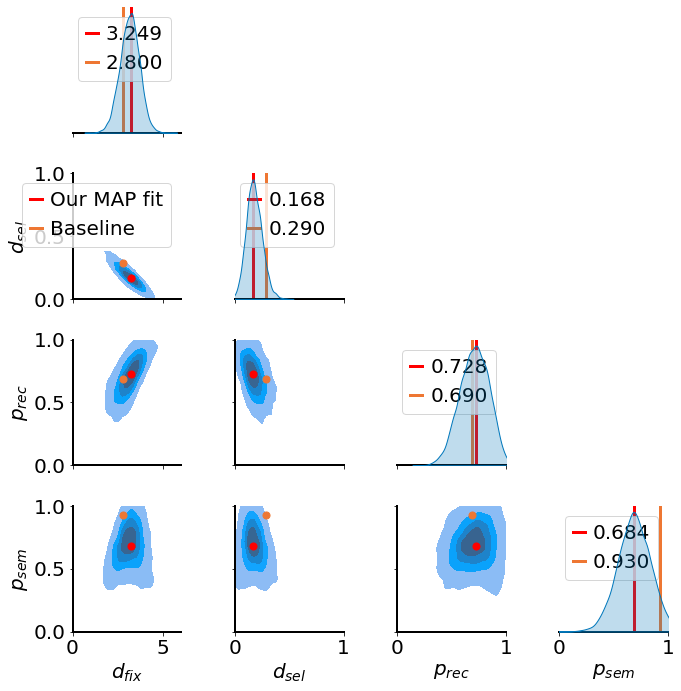

In [6]:
# amortizer.infer() returns the inferred free parameters
# and the samples to identify the posterior distribution
menu_trainer.amortizer.eval()
group_data_for_fitting = np.expand_dims(group_data_for_fitting, axis=0)
inferred_params, samples = menu_trainer.amortizer.infer(
    group_data_for_fitting,
    n_sample=10000,
    type="mode",
    return_samples=True
)
inferred_params = menu_trainer._clip_params(inferred_params)
print("inferred_params: ", inferred_params)

menu_trainer._pair_plot(
    samples,
    menu_trainer.param_symbol,
    limits=[[0., 6.], [0., 1.], [0., 1.], [0., 1.]],
    gt_params=menu_trainer.base_params,
    fname="user_posterior"
)

## Parameter recovery performance

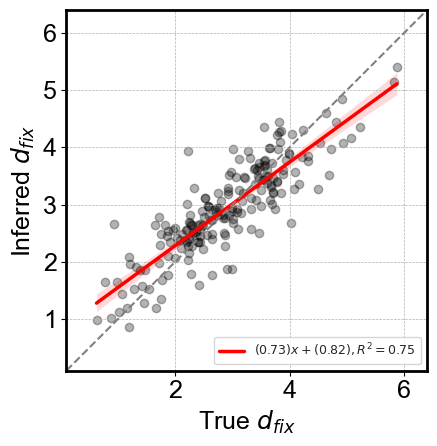

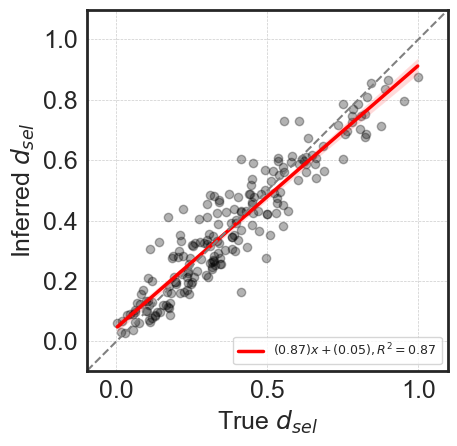

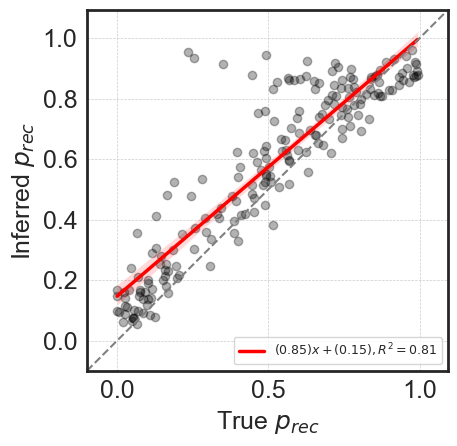

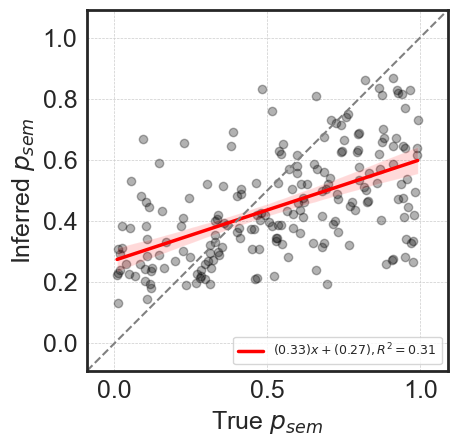

{'Parameter_Recovery/r2_d_fix': 0.746855996686667, 'Parameter_Recovery/r2_d_sel': 0.8732236953948957, 'Parameter_Recovery/r2_p_rec': 0.8137784274723854, 'Parameter_Recovery/r2_p_sem': 0.30578978108561294}


In [7]:
# From the simulated dataset,
# it is also possible to how the tranined model well recover the true parameters
gt_params, valid_data = menu_trainer.valid_dataset.sample()
res = dict()
menu_trainer.parameter_recovery(
    res,
    gt_params,
    valid_data,
    n_sample=10000,
    infer_type="mode",
    plot=True,
)
print(res)